# Using Spotify Data to Predict Music Review Scores, or "Just *How* Trash is my Music Taste?"



Since its inception in 1995, the music review blog Pitchfork has become notorious in independent music circles. Their coverage has been known to both elevate unknown and underground talent (their highest reviewed albums are  mostly [indie and more inaccesible music](https://pitchfork.com/best/high-scoring-albums/?page=5)), but its influence also has come at the cost of many bands being demolished entirely (see: infamous reviews of the bands [Jet](https://pitchfork.com/reviews/albums/9464-shine-on/) and [Black Kids](https://pitchfork.com/reviews/albums/11617-partie-traumatic/)). Many of its most famous reviews have seemingly shifted the culture and conversation around musicians, influencing other outlets opinions, like its unabashed praise of Kanye West's [My Beautiful Dark Twisted Fantasy](https://pitchfork.com/reviews/albums/14880-my-beautiful-dark-twisted-fantasy/). Although their influence has waned in recent years with the growing popularity of other review outlets like The Needle Drop or the website Rate Your Music, it still maintains its status as a crucial tastemaker among many circles for its consistently off-the-wall and obscure taste. 

The purpose of this project is to see if we can model the idiosyncratic tastes of the Pitchfork staff in a quantitative way. From [Kaggle](https://www.kaggle.com/nolanbconaway/pitchfork-data) I have found a dataset that has every single review score that the website has given out over the past 20+ years until 2017, categorized by genre and a number of other metrics. Using this, combined with specific Spotify track features for the songs on those albums, we are going to explore markers for what Pitchfork considers "good" music, and whether there is any specific music "signature" that Pitchfork's highest reviews tend to gravitate towards. 

Using this data, we can create a model to rate any given Spotify playlist or album, giving it its own Pitchfork score. Is your playlist "Best New Music"? Let's find out!

In [13]:
import sqlite3
import pandas 
import matplotlib.pyplot as plt
import numpy as np
import requests
#the next line imports a file containing api keys
from credentials import CLIENT_ID, CLIENT_SECRET
import json
import matplotlib.pyplot as plt

#base urls for Spotify API
AUTH_URL = 'https://accounts.spotify.com/api/token'
API_URL = 'https://api.spotify.com/v1/'
SEARCH_URL = 'https://api.spotify.com/v1/search'
TRACKS_URL = 'https://api.spotify.com/v1/tracks'
TRACK_URL = "https://api.spotify.com/v1/albums/" #"/{id}/tracks"

In [14]:
db = 'database.sqlite'
conn = sqlite3.connect(db)
display(conn)

Table of Contents:

* Introduction
    * Motivation
    * Relevance
* Data Collection / Processing
    * calling spotify web API
        * for song in each album, find average of metrics, add to table
* EDA / Visualization
    * graph metrics vs. score
    * if no conclusion, then try to combine features
    * check for biases (e.g.preference towards/against wordiness by genre)
    * observations / analysis
* Machine Learning model for metrics vs. score
    * random forrest?
* Plug my own spotify data into the model


# Data collection/cleanup

First, we need to gather some data from the given database. The sqlite database is split up into several tables. The relevant ones we will use are years, genres, and reviews. Luckily, they all share the same primary key (reviewid) which will make joining the tables simple. 

Afterwards, we must do some cleanup of the data in order to make computations simpler. First, I rename the "year" column to "year_released" for clarity. Then, I convert that row's data type to ints instead of floats to compare it to other fields.   

In [15]:
# joining data from the years table (year of album release) and genres table

query = """SELECT * FROM reviews
            INNER JOIN years 
                ON reviews.reviewid == years.reviewid 
            INNER JOIN genres
                ON reviews.reviewid == genres.reviewid
            """
reviews = pandas.read_sql(query, conn)

reviews = reviews.rename(columns={"year": "year_released"})

#changing year_released column to ints instead of floats
reviews['year_released'] = reviews['year_released'].fillna(-1)
reviews['year_released'] = reviews['year_released'].astype(int)
reviews['year_released'] = reviews['year_released'].replace('-1', np.nan)

#removing duplicate columns
reviews = reviews.loc[:,~reviews.columns.duplicated()]

Pitchfork, and the music press in general, is sometimes controversially known for having periodic critical reevaluations of works that were originally not well recieved. One cannonical example of this is Weezer's *Pinkerton*, which was lambasted by the music press on its release in 1996, but whose musical influence was so great that, upon a deluxe rerelease in 2010, Pitchfork awarded it a [perfect 10/10 score](https://pitchfork.com/reviews/albums/14817-weezer-pinkerton-deluxe-edition-death-to-false-metal/)(\*). Another example of this is the reaction to Hip-Hop producer J-Dilla's final (non-posthumous) album *Donuts*. The album was well recieved, but not exceptionally so -- Pitchfork awarded it a 7.9; Rolling Stone gave it a 3.5/5. However, over time the influence of the album grew, and on its reissue, Pitchfork gave it a [10/10](https://pitchfork.com/reviews/albums/17510-donuts-45-box-set/).


Taking this into account, to better model the idiosyncrasies of Pitchfork, whose takes are often odd in their own iconic way, I have dropped all rows where the review date is over a year longer than after the release date. This allows only the "freshest" opinions to be considered.

Likewise, in order to minimize the number of API calls needed down the road, I have also dropped all the rows whose albums are not in the rock genre. Rock makes up the greatest percentage of Pitchfork reviews (See the pie chart below), and from a cursory glance at the head of the data, also comprises a wide variety of sounds between harder rock and more indie music. This will give the most diversity in sounds so that the song features data can be sufficiently developed.

(\*) More information about Weezer's critical reevaluation can be found [here](https://www.rollingstone.com/music/music-features/how-weezers-pinkerton-went-from-embarrassing-to-essential-105567/)

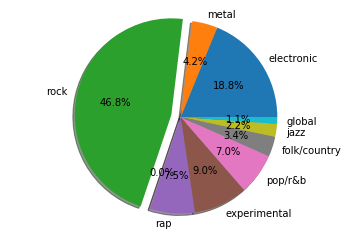

In [16]:
# Pie chart of number of Pitchfork reviews by genre
sizes = []
#print(labels)
labels = reviews.genre.unique()
#print(len(labels))
explode = (0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0)  
for genre in reviews.genre.unique():
    #print(str(genre) + " reviews: " + str(len(reviews[(reviews.genre == genre)])))
    sizes.append(len(reviews[(reviews.genre == genre)]))
    
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, explode=explode)
plt.axis('equal')
plt.show()


In [17]:
reviews = reviews[(reviews.genre == "rock")]
reviews = reviews[reviews.pub_year - reviews.year_released <= 2]
print("there are " + str(len(reviews)) + " total Pitchfork reviews")
reviews.head()

there are 9187 total Pitchfork reviews


,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,year_released,genre
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,2016,rock
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,2016,rock
23,22718,not the actual events ep,nine inch nails,http://pitchfork.com/reviews/albums/22718-not-...,6.3,0,benjamin scheim,contributor,2016-12-28,2,28,12,2016,2016,rock
26,22695,"early tapes, 1996-1998",the microphones,http://pitchfork.com/reviews/albums/22695-earl...,6.5,0,benjamin scheim,contributor,2016-12-27,1,27,12,2016,2016,rock
29,22532,turn into,jay som,http://pitchfork.com/reviews/albums/22532-turn...,8.2,0,quinn moreland,assistant editor,2016-12-23,4,23,12,2016,2016,rock


The next bit of code is some boilerplate needed to start using the Spotify API. CLIENT_ID and CLIENT_SECRET for this project are obtained through the Spotify Web API dashboard interface. They are located in a file called credentials.py in this directory. That file has not been uploaded for obvious reasons. Using CLIENT_ID and CLIENT_SECRET, we then send a POST request to the Spotify API which will return an access token. Using this, we can start querying the Web API.

In [18]:
#testing out the spotify API

#Some boilerplate needed to start querying the Spotify API
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
})

access_token = auth_response.json()['access_token']
headers = {
    'Authorization': 'Bearer {token}'.format(token=access_token),
    'Accept': 'application/json',
    'Content-Type': 'application/json'
}

Now, we need to get some information about every album in the pared down list of reviews. Spotify has an API that will return some features like Dancability, Acousticness and Liveness about a track. However, to access the endpoint for those features, Spotify needs their own internal ID for that track. However, we only have a list of albums. This means that the flow of API calls will need to be:
1. query for each album's spotifyID (This will remove a chunk of albums that aren't on Spotify)
2. using album ID for each album, query for the spotifyID of each song on it
3. for each song's spotify ID, query for the audio features

To prevent the API calls taking a long time every time the notebook is run, I ran the calls once, wrote the results to disk, and read from those files in subsequent runs. The code to generate the API calls is also included.

In [19]:
# This code was used to generate the initial ids.
# This uses the Spotify web API search endpoint to get the spotify ID of an album
# They were then saved to a file so that further API calls would be unnecesary
# Subsequent runs of the program read from the file created, titled rock_ids.txt

"""
ids = []
for idx, rev in reviews.iterrows():
    query = "album:" + rev['title'] + " artist:" + rev['artist']
    #print(query)
    payload = {
        'q' : query,
        'type' : 'album'
    }
    #print(payload)
    g = requests.get(
        url = SEARCH_URL,
        headers = headers,
        params = payload
    )
    print(g.status_code)
    print(idx)
    r = json.loads(g.text)
    if (len(r['albums']['items']) != 0):
        ids.append(r['albums']['items'][0]['id'])
    else: 
        ids.append("0")
"""

# The following code was run to write the results of the API calls to disk
"""
f = open("rock_ids.txt", "w")

for id in ids:
    f.write('%s\n' % id)
"""

'\nf = open("rock_ids.txt", "w")\n\nfor id in ids:\n    f.write(\'%s\n\' % id)\n'

In [20]:
# reading ids from the text file
with open('rock_ids.txt', 'r') as f:
    ida = [line.strip() for line in f]
#print(ida)

reviews["spotify_id"] = ida
reviews.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,year_released,genre,spotify_id
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,2016,rock,5M3Cx38HT8sD8ulnrSZsXi
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,2016,rock,0
23,22718,not the actual events ep,nine inch nails,http://pitchfork.com/reviews/albums/22718-not-...,6.3,0,benjamin scheim,contributor,2016-12-28,2,28,12,2016,2016,rock,0
26,22695,"early tapes, 1996-1998",the microphones,http://pitchfork.com/reviews/albums/22695-earl...,6.5,0,benjamin scheim,contributor,2016-12-27,1,27,12,2016,2016,rock,4MidlO3UE5TXZ7NK0Nloc8
29,22532,turn into,jay som,http://pitchfork.com/reviews/albums/22532-turn...,8.2,0,quinn moreland,assistant editor,2016-12-23,4,23,12,2016,2016,rock,3hGEiHWq02qRrTIWqJrk7U


Some of the results of this initial pruning were dissapointing. For instance, in the head of the resulting spotify ID grab (see above), the *Not the Actual Events EP* from Nine Inch Nails does not seem to have a matching spotify id, despite the fact that I *know* I have actually listened to this album on Spotify before(\*). This discrepancy could stem from issues in accurate titling across the database paired with the fact that the API search was not a fuzzy search and included the entire text of the title and the artist. An area for possible improvement could be better entity resolution. However, with the scope (and time limit!) of this project, a deep dive into total accuracy might be overkill. Alas. Onward!

(\*) actual screenshot of my last.fm scrobbles (listens) of Nine Inch Nails songs. I have listened to 1 track off *Not the Actual Events EP* exactly once
<img src="NIN_scrobbles.png" width = 50% height = 50%/>


In [21]:
#some extra cleanup
reviews = reviews[reviews["spotify_id"] != "0"]
reviews = reviews.reset_index()
reviews.head()

,index,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,year_released,genre,spotify_id
0,2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,2016,rock,5M3Cx38HT8sD8ulnrSZsXi
1,26,22695,"early tapes, 1996-1998",the microphones,http://pitchfork.com/reviews/albums/22695-earl...,6.5,0,benjamin scheim,contributor,2016-12-27,1,27,12,2016,2016,rock,4MidlO3UE5TXZ7NK0Nloc8
2,29,22532,turn into,jay som,http://pitchfork.com/reviews/albums/22532-turn...,8.2,0,quinn moreland,assistant editor,2016-12-23,4,23,12,2016,2016,rock,3hGEiHWq02qRrTIWqJrk7U
3,38,22469,"passion, pain & demon slayin",kid cudi,http://pitchfork.com/reviews/albums/22469-pass...,6.7,0,matthew strauss,associate editor,2016-12-20,1,20,12,2016,2016,rock,5bCk3kWAy2JbbTfHqzZCII
4,65,22627,welcome to sideways,simian mobile disco,http://pitchfork.com/reviews/albums/22627-welc...,6.8,0,cameron cook,contributor,2016-12-10,5,10,12,2016,2016,rock,2G3UeKEm8QKU0hP3BGOdKm


In [22]:
print(reviews.shape)

(7089, 17)


Now we must use the API to get spotifyIDs for each song on each album.

We then create a new dataframe for each song of each album that was reviewed. With this, we can easily connect feature data later. Once again, to limit API calls, the code was run and the results were written to disk and read from in subsequent runs of the program.

In [30]:
# the following code was run once to generate a csv file titled song_ids.csv.
# The file contains columns for song spotify id, review_id, and song_title

"""songs = pandas.DataFrame(columns=['reviewid', 'song_title', 'spotify_id'])

for idx, review in reviews.iterrows():
    print(str(idx) + " " + review.title)
    payload = {
        'ids' : review.spotify_id
    }
    g = requests.get(
        url = TRACK_URL,
        headers = headers,
        params = payload
    )
    r = json.loads(g.text)
    for track in r['albums'][0]['tracks']['items']:
        #print(track['name'])
        new_row = {'reviewid':review.reviewid, 'song_title':track['name'], 'soptify_id': track['id']}
        songs = songs.append(new_row, ignore_index=True)
        
songs.to_csv("song_ids.csv")"""

#the last line writes the dataframe to disk

'songs = pandas.DataFrame(columns=[\'reviewid\', \'song_title\', \'spotify_id\'])\n\nfor idx, review in reviews.iterrows():\n    print(str(idx) + " " + review.title)\n    payload = {\n        \'ids\' : review.spotify_id\n    }\n    g = requests.get(\n        url = TRACK_URL,\n        headers = headers,\n        params = payload\n    )\n    r = json.loads(g.text)\n    for track in r[\'albums\'][0][\'tracks\'][\'items\']:\n        #print(track[\'name\'])\n        new_row = {\'reviewid\':review.reviewid, \'song_title\':track[\'name\'], \'soptify_id\': track[\'id\']}\n        songs = songs.append(new_row, ignore_index=True)\n        \nsongs.to_csv("song_ids.csv")'

In [27]:
songs2 = pandas.read_csv('song_ids.csv')

songs2.head()

,Unnamed: 0,reviewid,song_title,spotify_id,soptify_id
0,0,22659,Introduction,NaN,0ixa7hOenvqfHYe2Rh6ZIb
1,1,22659,That Clown's Got A Gun,NaN,4yjlM9f8HSeUc9qWVTrKd2
2,2,22659,The Lottery,NaN,76r8GMCfAFttfKqvTKH623
3,3,22659,God's Chest,NaN,7ys9JxHIV3QlJXPDQ6vbkc
4,4,22659,Who Made The Man?,NaN,7ib5NOykP6HOG6VdjeS6qz
